## Regression model with PyTorch


In [1]:
import numpy as np
import pandas as pd
import torch
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F

In [2]:
plt.style.use('seaborn')

In [3]:
datapath = os.path.join(os.getcwd(), 'forestfires.csv')

In [4]:
df = pd.read_csv(datapath)

### Build models

In [5]:
# model 1: not scaled or transformed with area as a target variable. 
# area is very skewed towards 0, it can have a bad impact on the result.
#     features: ['FFMC','temp','RH','wind','rain', 'ISI']
#     target: 'area'

In [6]:
# convert to pytoch dataset
batch_size = 20

def get_dl(inputs, targets, batch_size):
    dataset = TensorDataset(torch.tensor(inputs, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32))

    # we'll split data into train and test using random split 
    train, val = random_split(dataset, [450, 67])

    # create data loaders
    train_dl = DataLoader(train, batch_size = batch_size, shuffle = True)
    val_dl = DataLoader(val, batch_size = batch_size, shuffle = True)
    
    return train_dl, val_dl
    
    

In [7]:
# model 1 data
inputs1 = df[['FFMC','temp','RH','wind','rain', 'ISI']].values
target1 = df['area'].values

train_dl1, val_dl1 = get_dl(inputs1, target1, batch_size=batch_size)

In [8]:
# input and output sizes are the same for all models. input = 1 and putput = 6.
output_size = 1
input_size = 6

In [9]:
# a simple linear model
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        
        output = self.linear(x)
        return output    

In [10]:
def train_model(model, optimizer, train_dl, epochs):
    history = []
    
    for e in range(epochs):
#         print(f'Epoch # %s' %e)
        losses = 0

        for i, (inputs, targets) in enumerate(train_dl):
#             print(f'    Batch # %s' %i)

            out = model(inputs).squeeze() #predictions
            loss = F.l1_loss(out, targets) # loss
            loss.backward()
#             print('Loss: %s' %loss)
            optimizer.step()
            losses += loss
            optimizer.zero_grad()

        history.append(losses/len(train_dl))
    return history
        
        

In [11]:
def val_model(model, val_dl):
    
    losses = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_dl):
            out = model(inputs).squeeze() #predictions
            loss = F.l1_loss(out, targets) # loss
            losses += loss
    val_loss = losses/len(val_dl)
    
    return val_loss
        
        

In [12]:
def plot_history(history):
    fig, axes = plt.subplots(figsize = (10, 6))
    plt.plot(history, '-x')

    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.title('Training loss')
    plt.show()

In [13]:
model1 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model1.parameters(), lr= 0.001)
history1 = train_model(model1, optimizer, train_dl1, epochs=epochs)

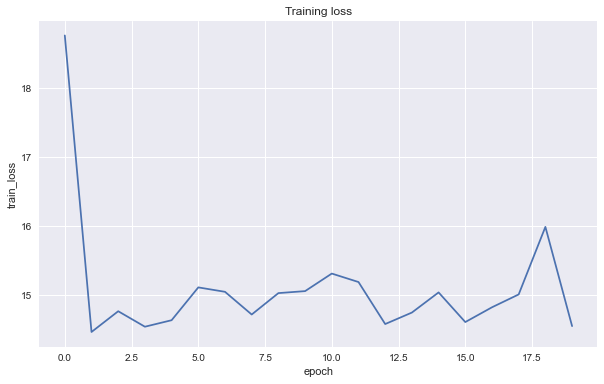

In [14]:
plot_history(history1)

In [15]:
model1 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model1.parameters(), lr= 0.0001)
history1 = train_model(model1, optimizer, train_dl1, epochs=epochs)

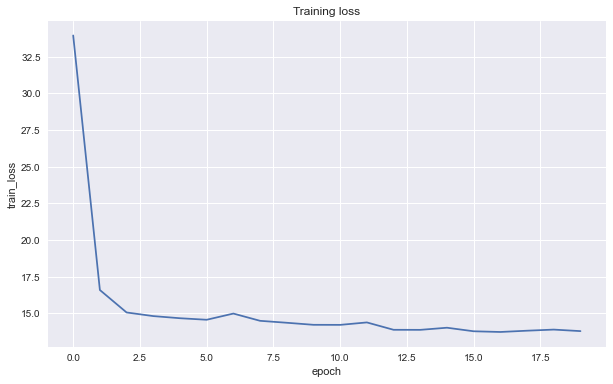

In [16]:
plot_history(history1)

This model uses all unscaled variables and a traget too skewed to 0. Training loss per epoch goes down but has many peaks. The model finds it hard to converge. The same demonstrates the evaluation scores. The smaller learning rate performs better.

In [17]:
# model 2

In [18]:
def log_transform(x):
    return np.log(x + 1)

In [19]:
# model 2 data
# We log transform are to get more homogenious values
df['area_log'] = df['area'].apply(lambda x: log_transform(x))

inputs2 = df[['FFMC','temp','RH','wind','rain', 'ISI']].values
target2 = df['area_log'].values

train_dl2, val_dl2 = get_dl(inputs2, target2, batch_size=batch_size)

In [20]:
model2 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model2.parameters(), lr= 0.001)
history2 = train_model(model2, optimizer, train_dl2, epochs=epochs)


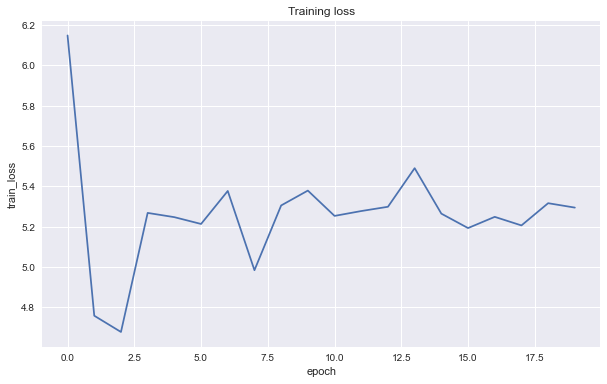

In [21]:
plot_history(history2)

In [22]:
print('Evaluate on training: {:.4f}'.format(val_model(model1, train_dl2)))
print('Evaluate on validation : {:.4f}'.format(val_model(model1, val_dl2)))

Evaluate on training: 1.5309
Evaluate on validation : 1.3698


Second model uses as a target area_log, that is a log transformed area. This may help to get better results. What we see is that the loss drops significantly and then stays on the same levels having peaks up an down.
Transforming the target helped a model to converge faster though still at certain level it is hard for the model to learn.

In [23]:
# model 3

In [24]:
# model 3 data

inputs3 = df[['FFMC','temp','RH','wind','rain', 'area']].values
target3 = df['ISI'].values

train_dl3, val_dl3 = get_dl(inputs3, target3, batch_size=batch_size)

In [25]:
model3 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model3.parameters(), lr= 0.001)
history3 = train_model(model3, optimizer, train_dl3, epochs=epochs)

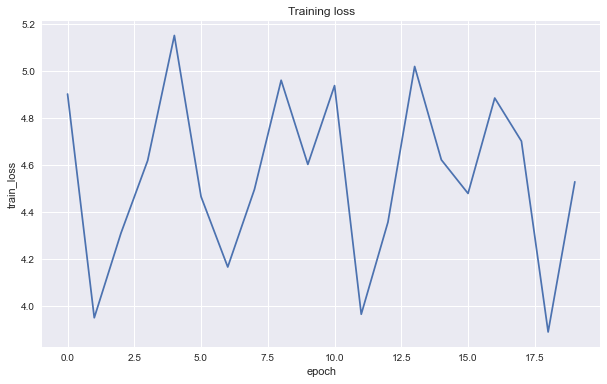

In [26]:
plot_history(history3)

In [27]:
print('Evaluate on training: {:.4f}'.format(val_model(model1, train_dl3)))
print('Evaluate on validation : {:.4f}'.format(val_model(model1, val_dl3)))

Evaluate on training: 7.7594
Evaluate on validation : 8.1120


In [ ]:
# it's hard to say the model has trained well, the loss curve doe

In [28]:
model3 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model3.parameters(), lr= 0.0001)
history3 = train_model(model3, optimizer, train_dl3, epochs=epochs)

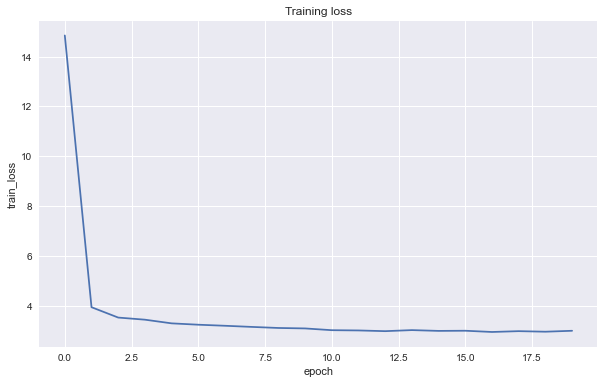

In [29]:
plot_history(history3)

The model number 3 uses unscaled features and target. Target in this case is ISI: Initial Spread Index that indicates  estimate a fire spread potential.
Training losses decrease drastically during the first epochs, then the loss goes up and down. If the learning rate is bigger, the model finds it more difficult to learn.